In [1]:
import pickle
import gzip
import os
import time
import copy
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Utility Functions

In [8]:
def print_train_data_point(item, verbose=False):
    name = item['name']   #
    video = item['video'] #
    box = item['box']
    label = item['label']
    frames = item['frames'] #
    dataset = item['dataset'] #
    
    print(f"Dataset: {dataset}, Name: {name}\nVideo Shape:   {video.shape}\nLabeld Frames: {frames}")
    if verbose:
        print(f"Box Shape:   {box.shape}\nLabel Shape: {label.shape}")
    print()
    
def resize_boolean_array(b_item, shape=(256, 256)):
    # Step 1: Convert boolean to uint8 (True -> 255, False -> 0)
    b_item_uint8 = b_item.astype(np.uint8) * 255
    
    # Step 2: Resize the array with nearest-neighbor interpolation
    size = (shape[1],shape[0])
    resized_item = cv2.resize(b_item_uint8, size, interpolation=cv2.INTER_NEAREST)
    
    # Step 3: Convert back to boolean (any value >= 127 is True)
    resized_item_boolean = resized_item >= 127
    
    return resized_item_boolean

def extract_box_center_batch(boolean_batch):
    
    batch_size = boolean_batch.shape[0]
    coordinates = []
    
    for i in range(batch_size):
        boolean_array = boolean_batch[i]
        height, width = boolean_array.shape
        #print(boolean_array)
        
        x1 = None
        y1 = None
        x2 = None
        y2 = None
        i = 0
        
        for h in range(height):
            for w in range(width):
                if boolean_array[h][w] == True:
                    x2, y2 = h, w
                    if (i==0):
                        x1, y1 = h, w
                    i += 1
        
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        coordinates.append((center_x, center_y))
            
    return torch.FloatTensor(np.array(coordinates))

def reconstruct_box_centers_batch(coords_batch, shape=(256,256), box_width=96, box_height=96):
    # box_width and box_height are swaped :D
    batch_size = coords_batch.shape[0]
    boxes = []
    half_width = box_width // 2
    half_height = box_height // 2 
    
    for i in range(batch_size):
        center_x, center_y = coords_batch[i,:].detach().numpy().astype(int)
        box = np.zeros(shape, dtype=bool)
        
        # Calculate box boundaries
        x1 = max(0, center_x - half_width)
        x2 = min(shape[0] - 1, center_x + half_width)
        y1 = max(0, center_y - half_height)
        y2 = min(shape[1] - 1, center_y + half_height)
        
        box[x1:x2+1, y1:y2+1] = True
        boxes.append(box)
    
    return torch.BoolTensor(np.array(boxes))

def calculate_box_area(x1, y1, x2, y2):
    # Ensure the coordinates are within the image bounds
    if x1 < 0 or y1 < 0 or x2 > 256 or y2 > 256:
        raise ValueError("Box coordinates are outside the image bounds.")
    if x1 >= x2 or y1 >= y2:
        raise ValueError("Invalid box coordinates: (x1, y1) must be top-left and (x2, y2) bottom-right.")
    
    # Calculate the width and height of the box
    width = x2 - x1
    height = y2 - y1
    
    # Calculate and return the area
    return width * height

def substitute_with_my_box(box):
    #takes given box
    #returns box with same center but 50x50
    
    box_batch = torch.BoolTensor(box).unsqueeze(0)
    center_batch = extract_box_center_batch(box_batch)
    my_box_batch = reconstruct_box_centers_batch(center_batch)
    
    return my_box_batch[0].detach().numpy()

def get_cropped_frame(frame, box, shape=(96,96)):

    height, width = box.shape
    
    cropped_frame = np.zeros((96, 96), dtype=float)
        
    x1 = None
    y1 = None
    x2 = None
    y2 = None
    i = 0

    for h in range(height):
        for w in range(width):
            if box[h][w] == True:
                x2, y2 = h, w
                if (i==0):
                    x1, y1 = h, w
                i += 1
                
    cropped_frame[0:(x2-x1), 0:(y2-y1)] = frame[x1:x2, y1+1:y2+1]
                    
    return cropped_frame

## Graphing Functions

In [11]:
def plot_frame(frame, title, mask=None):
    
    # Apply the mask to the copy if provided
    frame_with_mask = frame.copy()
    frame_without_mask = frame.copy()
    if mask is not None:
        frame_with_mask[~mask] = 0
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(frame_without_mask, cmap='gray')
    title0 = title + " without mask"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(frame_with_mask, cmap='gray')
    title1 = title + " with mask"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()
    
def show_video(frames, masks, speed=0.025):
    
    video = frames.copy()
    masked_video = video * masks  # Apply the mask to each frame
    
    num_frames = video.shape[2]
    plt.figure(figsize=(10, 5))
    
    for i in range(num_frames):
        plt.clf()  # Clear the previous plot
        
        # Left subplot: Original video
        plt.subplot(1, 2, 1)
        plt.imshow(video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Original Frame {i+1}/{num_frames}")
        
        # Right subplot: Masked video
        plt.subplot(1, 2, 2)
        plt.imshow(masked_video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Masked Frame {i+1}/{num_frames}")
        
        # Display and wait
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(speed)

## Models

In [14]:
class BoxModel(nn.Module):
    def __init__(self):
        super(BoxModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (batch_size, 16, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 16, 128, 128)
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (batch_size, 32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (batch_size, 64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 64, 32, 32)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),  # Reduced number of neurons
            nn.ReLU(),
            #nn.Dropout(0.1),  # Optional regularization
            nn.Linear(512, 2)  # Output x, y coordinates
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling path)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling path)
        self.upconv4 = self.upconv_block(1024, 512)
        self.dec4 = self.conv_block(1024, 512)  # 512 (up) + 512 (cropped encoder)

        self.upconv3 = self.upconv_block(512, 256)
        self.dec3 = self.conv_block(512, 256)  # 256 (up) + 256 (cropped encoder)

        self.upconv2 = self.upconv_block(256, 128)
        self.dec2 = self.conv_block(256, 128)  # 128 (up) + 128 (cropped encoder)

        self.upconv1 = self.upconv_block(128, 64)
        self.dec1 = self.conv_block(128, 64)   # 64 (up) + 64 (cropped encoder)

        # Output layer with target size (N, 1, 96, 96)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with Conv2D + BatchNorm + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block with ConvTranspose2D"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def crop_and_concat(self, encoder_features, decoder_features):
        """Crop encoder features to match decoder dimensions and concatenate"""
        _, _, H, W = decoder_features.size()
        _, _, H_enc, W_enc = encoder_features.size()
        crop_h = (H_enc - H) // 2
        crop_w = (W_enc - W) // 2
        enc_cropped = encoder_features[:, :, crop_h:crop_h+H, crop_w:crop_w+W]
        return torch.cat([enc_cropped, decoder_features], dim=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                           # (N, 64, 256, 256)
        enc2 = self.enc2(F.max_pool2d(enc1, 2, 2))    # (N, 128, 128, 128)
        enc3 = self.enc3(F.max_pool2d(enc2, 2, 2))    # (N, 256, 64, 64)
        enc4 = self.enc4(F.max_pool2d(enc3, 2, 2))    # (N, 512, 32, 32)

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2, 2))  # (N, 1024, 16, 16)

        # Decoder
        up4 = self.upconv4(bottleneck)                # (N, 512, 32, 32)
        dec4 = self.dec4(self.crop_and_concat(enc4, up4))  # (N, 512, 32, 32)

        up3 = self.upconv3(dec4)                      # (N, 256, 64, 64)
        dec3 = self.dec3(self.crop_and_concat(enc3, up3))  # (N, 256, 64, 64)

        up2 = self.upconv2(dec3)                      # (N, 128, 128, 128)
        dec2 = self.dec2(self.crop_and_concat(enc2, up2))  # (N, 128, 128, 128)

        up1 = self.upconv1(dec2)                      # (N, 64, 256, 256)
        dec1 = self.dec1(self.crop_and_concat(enc1, up1))  # (N, 64, 256, 256)

        # Output
        out = self.out_conv(dec1)                     # (N, 1, 256, 256)
        out = F.interpolate(out, size=(96, 96), mode='bilinear', align_corners=False)
        return torch.sigmoid(out)  # Final shape: (N, 1, 96, 96)

## Load Test Data

In [11]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
# load data
test_data = load_zipped_pickle("test.pkl")

## Load Trained Models

In [20]:
box_model = torch.load("models/box_model.pth")
unet_model = torch.load("models/unet_model.pth")

C:\Users\marti\AppData\Local\Temp\ipykernel_12988\3948645785.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  box_model = torch.load("models/box_model.pth")
C:\Users\mart

## Box Model Testing

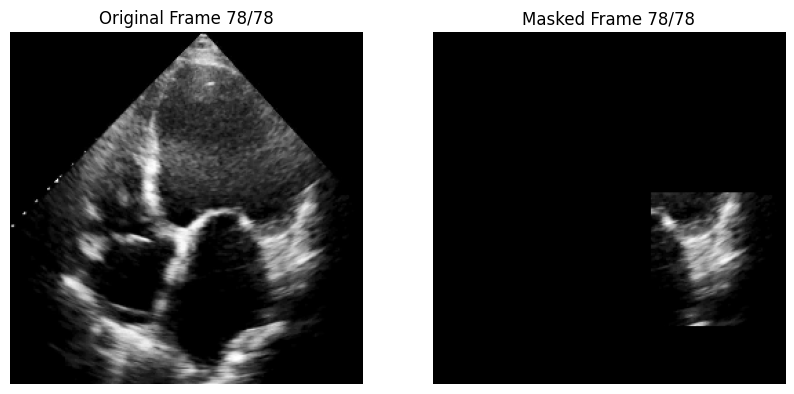

In [22]:
test_video = test_data[12]['video']
vid = np.zeros((256,256,test_video.shape[2]))
for i in range(test_video.shape[2]):
    vid[:,:,i] = cv2.resize(test_video[:,:,i].astype(np.uint8), (256, 256))
   
vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)

box_model.eval()
frame_box_coords = box_model(frames)
boxes = reconstruct_box_centers_batch(frame_box_coords)

video_frames = frames.squeeze().permute(1, 2, 0)
video_boxes = boxes.permute(1, 2, 0)

show_video(frames=video_frames.detach().numpy(), masks=video_boxes.detach().numpy(), speed=0.0001)

## Unet Testing

C:\Users\marti\AppData\Local\Temp\ipykernel_12988\3063239865.py:123: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cropped_frame[0:(x2-x1), 0:(y2-y1)] = frame[x1:x2, y1+1:y2+1]


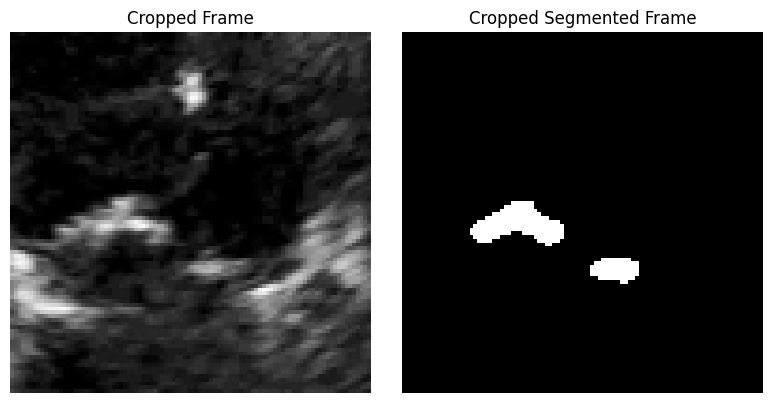

In [24]:
test_video_0 = test_data[17]['video']
vid = np.zeros((256,256,test_video_0.shape[2]))
for i in range(test_video_0.shape[2]):
    vid[:,:,i] = cv2.resize(test_video_0[:,:,i].astype(np.uint8), (256, 256))
    
vid = vid[:,:,0:5]
vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)

box_model.eval()
frame_box_coords = box_model(frames)
frames = frames.squeeze()
boxes = reconstruct_box_centers_batch(frame_box_coords)

cropped_frames = []
for i in range(5):
    cropped_frames.append(get_cropped_frame(frames[i], boxes[i]))
    
cropped_frames = torch.FloatTensor(np.array(cropped_frames))
cropped_frames = cropped_frames.unsqueeze(1)


unet_model.eval()
segmented_cropped_frame = unet_model(cropped_frames)
#print("Segmented Cropped Frames shape:")
#print(segmented_cropped_frame.shape)

for i in range(1):
    abba = segmented_cropped_frame[i].squeeze().detach().numpy()
    abba = abba > 0.5

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(cropped_frames[i,:,:].squeeze(), cmap='gray')
    title0 = "Cropped Frame"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(abba, cmap='gray')
    title1 = "Cropped Segmented Frame"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()

## Get Full Prediction

In [27]:
def decrop_video(video, video_centers):
    video_centers = video_centers.detach().numpy()
    video = video.detach().numpy()
    
    uncropped_video = np.zeros((video.shape[0], 256, 256), dtype=bool)
    
    top_lefts = []
    for i in range(video.shape[0]):
        center = video_centers[i,:]
        top_lefts.append((center[0]-48., center[1]-48.))
        
    top_lefts = np.array(top_lefts).astype(int)
    
    for i in range(video.shape[0]):
        video[i,:,:] = video[i,:,:] > 0.5
        for j in range(96):
            for k in range(96):
                if((j + top_lefts[i][0] < 256) and (k + top_lefts[i][1] < 256)):
                    uncropped_video[i][j + top_lefts[i][0]][k + top_lefts[i][1]] = video[i][j][k]
                
    return uncropped_video

In [32]:
segmented_videos = []

for item in tqdm(test_data):
    video = item['video']
    original_height, original_width, _ = video.shape 
    
    video = cv2.resize(video.astype(np.uint8), (256, 256))
    video = video.transpose((2, 0, 1))
    video = np.expand_dims(video, axis=1)
    video = torch.FloatTensor(video)
    
    box_model.eval()
    video_centers = box_model(video)
    boxes_video = reconstruct_box_centers_batch(video_centers)
    video = video.squeeze()
    
    cropped_frames = []
    for i in range(video.shape[0]):
        cropped_frames.append(get_cropped_frame(video[i,:,:], boxes_video[i,:,:]))

    cropped_video = torch.FloatTensor(np.array(cropped_frames))
    cropped_video = cropped_video.unsqueeze(1)
    
    unet_model.eval()
    segmented_cropped_video = unet_model(cropped_video)
    segmented_cropped_video = segmented_cropped_video.squeeze()
    
    segmented_video = decrop_video(segmented_cropped_video, video_centers)
    
    #Resize to original shape
    final_video = []
    for i in range(video.shape[0]):
        final_frame = resize_boolean_array(segmented_video[i,:,:], (original_height, original_width))
        final_video.append(final_frame)
    final_video = np.array(final_video)
    
    
    print(final_video.shape)
    segmented_videos.append(final_video)
    
print(len(segmented_videos))

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\marti\AppData\Local\Temp\ipykernel_12988\3063239865.py:123: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cropped_frame[0:(x2-x1), 0:(y2-y1)] = frame[x1:x2, y1+1:y2+1]


103


  5%|▌         | 1/20 [02:04<39:31, 124.84s/it]

(103, 586, 821)
52


 10%|█         | 2/20 [03:12<27:21, 91.17s/it] 

(52, 587, 791)
69


 15%|█▌        | 3/20 [04:39<25:18, 89.31s/it]

(69, 583, 777)
61


 20%|██        | 4/20 [05:57<22:34, 84.65s/it]

(61, 582, 851)
53


 25%|██▌       | 5/20 [07:02<19:27, 77.84s/it]

(53, 732, 845)
84


 30%|███       | 6/20 [08:43<19:57, 85.51s/it]

(84, 583, 809)
78


 35%|███▌      | 7/20 [10:14<18:57, 87.48s/it]

(78, 582, 737)
125


 40%|████      | 8/20 [12:50<21:52, 109.36s/it]

(125, 587, 775)
76


 45%|████▌     | 9/20 [14:24<19:07, 104.35s/it]

(76, 730, 956)
104


 50%|█████     | 10/20 [16:28<18:25, 110.51s/it]

(104, 587, 781)
68


 55%|█████▌    | 11/20 [17:53<15:23, 102.59s/it]

(68, 583, 681)
90


 60%|██████    | 12/20 [19:41<13:53, 104.20s/it]

(90, 587, 713)
78


 65%|██████▌   | 13/20 [21:15<11:48, 101.16s/it]

(78, 587, 612)
73


 70%|███████   | 14/20 [22:41<09:39, 96.59s/it] 

(73, 587, 773)
39


 75%|███████▌  | 15/20 [23:32<06:54, 82.81s/it]

(39, 707, 855)
72


 80%|████████  | 16/20 [24:57<05:34, 83.55s/it]

(72, 731, 1007)
106


 85%|████████▌ | 17/20 [27:04<04:50, 96.76s/it]

(106, 583, 780)
63


 90%|█████████ | 18/20 [28:21<03:01, 90.77s/it]

(63, 583, 670)
51


 95%|█████████▌| 19/20 [29:23<01:22, 82.18s/it]

(51, 594, 745)
62


100%|██████████| 20/20 [30:37<00:00, 91.86s/it]

(62, 583, 779)
20


## Save Segmented Videos

In [38]:
# Convert to a pandas DataFrame for saving
df = pd.DataFrame({'video': segmented_videos})

# Save using pickle
df.to_pickle("segs/videos.pkl")

In [5]:
# Reload
loaded_df = pd.read_pickle("segs/videos.pkl")
segmented_videos = loaded_df['video'].tolist()

# Verify
#print(f"Original shape: {segmented_videos[0].shape}, Reloaded shape: {reloaded_videos[0].shape}")
#print(f"Are they equal? {np.array_equal(segmented_videos[0], reloaded_videos[0])}")

## Final Visualisation

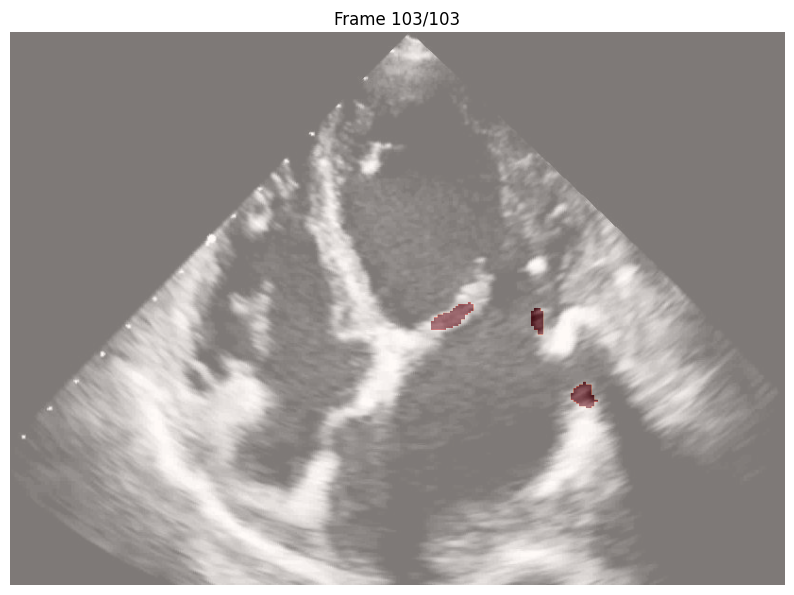

In [43]:
plt.figure(figsize=(10, 10))
index = 0
video = reloaded_videos[index]
num_frames = video.shape[0]
    
for i in range(num_frames):
    plt.clf()  
    plt.imshow(test_data[index]['video'][:,:,i], cmap='gray')
    plt.imshow(video[i, :, :], cmap="Reds", alpha=0.5)
    plt.axis('off')
    plt.title(f"Frame {i+1}/{num_frames}")

    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.001)

## Submission

In [16]:
flattend_list = []
for video in segmented_videos:
    video = video.astype(int)
    flattend_list.append(video.flatten())

In [20]:
def get_sequences(arr):
    first_indices, last_indices, lengths = [], [], []
    n, i = len(arr), 0
    arr = [0] + list(arr) + [0]
    for index, value in enumerate(arr[:-1]):
        if arr[index+1]-arr[index] == 1:
            first_indices.append(index)
        if arr[index+1]-arr[index] == -1:
            last_indices.append(index)
    lengths = list(np.array(last_indices)-np.array(first_indices))
    return first_indices, lengths

ids = []
first_indices = []
lengths = []
i=0
for item in tqdm(flattend_list):
    first_indice, length  = get_sequences(item)
    name = test_data[i]['name']
    i += 1
    ida = []
    for j in range(len(first_indice)):
        ida.append(name + "_" + str(j))
                   
    ids += ida
    first_indices += first_indice
    lengths += length

100%|██████████| 20/20 [06:22<00:00, 19.12s/it]


In [22]:
print(len(ids))
print(len(first_indices))
lengths = [int(x) for x in lengths]
print(len(lengths))
values = [[a, b] for a, b in zip(first_indices, lengths)]
print(len(values))
print(values[0])

127965
127965
127965
127965
[243558, 7]


In [24]:
df = pd.DataFrame({"id":ids, "value":values})
print(df)
df.to_csv(f"subs/submission_test_1.csv", index=False)

                     id          value
0          E9AHVWGBUF_0    [243558, 7]
1          E9AHVWGBUF_1    [244379, 7]
2          E9AHVWGBUF_2    [245149, 3]
3          E9AHVWGBUF_3   [245194, 16]
4          E9AHVWGBUF_4    [245970, 3]
...                 ...            ...
127960  UB7LFQKZT5_2280  [27952781, 7]
127961  UB7LFQKZT5_2281  [27953560, 7]
127962  UB7LFQKZT5_2282  [27954339, 7]
127963  UB7LFQKZT5_2283  [27955118, 7]
127964  UB7LFQKZT5_2284  [27955897, 7]

[127965 rows x 2 columns]
